In [1]:
import os, zipfile
import pandas as pd
import matplotlib.pyplot as plt
import requests

OUT_DIR = r"output"
os.makedirs(OUT_DIR, exist_ok=True)

CITIES = [
    ("Moscow", 55.7558, 37.6173),
    ("Saint Petersburg", 59.9311, 30.3609),
    ("Novosibirsk", 55.0084, 82.9357),
    ("Arkhangelsk", 64.5399, 40.5152),
    ("Sochi", 43.5855, 39.7231),
    ("Kazan", 55.7961, 49.1064),
    ("Nizhny Novgorod", 56.2965, 43.9361),
    ("Magadan", 59.5682, 150.8085),
]

START_DATE = "2024-01-16"
END_DATE   = "2024-01-19"

HOURLY_VARS = [
    "temperature_2m",
    "relative_humidity_2m",
    "pressure_msl",
    "wind_speed_10m",
    "wind_direction_10m",
    "precipitation",
    "cloud_cover",
]

def fetch_open_meteo(city, lat, lon):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": START_DATE,
        "end_date": END_DATE,
        "hourly": ",".join(HOURLY_VARS),
        "timezone": "auto"
    }
    r = requests.get(url, params=params, timeout=60)
    r.raise_for_status()
    js = r.json()
    df = pd.DataFrame(js["hourly"])
    df["city"] = city
    df["lat"] = lat
    df["lon"] = lon
    df["time"] = pd.to_datetime(df["time"], errors="coerce")
    return df

dfs = [fetch_open_meteo(c, lat, lon) for c, lat, lon in CITIES]
wx = pd.concat(dfs, ignore_index=True)

wx.shape, wx.head(3)


((768, 11),
                  time  temperature_2m  relative_humidity_2m  pressure_msl  \
 0 2024-01-16 00:00:00            -1.9                    89         992.3   
 1 2024-01-16 01:00:00            -2.0                    88         992.4   
 2 2024-01-16 02:00:00            -2.3                    88         992.4   
 
    wind_speed_10m  wind_direction_10m  precipitation  cloud_cover    city  \
 0            28.2                 190            0.2          100  Moscow   
 1            27.9                 195            0.1          100  Moscow   
 2            26.7                 194            0.1          100  Moscow   
 
        lat      lon  
 0  55.7558  37.6173  
 1  55.7558  37.6173  
 2  55.7558  37.6173  )

In [2]:
before = len(wx)
wx = wx.dropna(subset=["time","temperature_2m"]).drop_duplicates()
wx = wx.sort_values(["city","time"]).reset_index(drop=True)
print("Строк было -> стало:", before, "->", len(wx))


Строк было -> стало: 768 -> 768


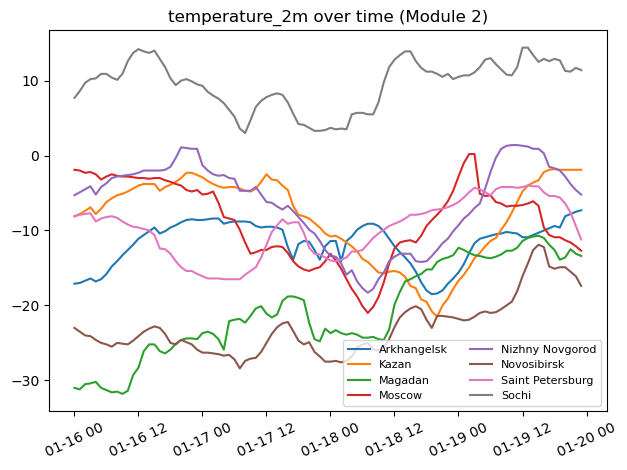

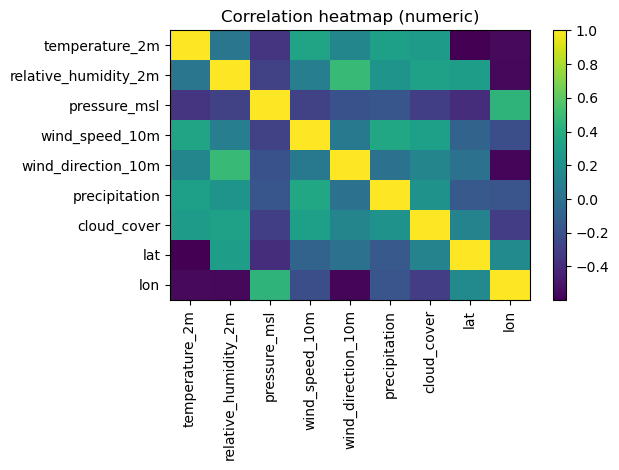

In [3]:
# 1) температура по времени по городам
plt.figure()
for city in wx["city"].unique():
    tmp = wx[wx["city"] == city]
    plt.plot(tmp["time"], tmp["temperature_2m"], label=city)
plt.title("temperature_2m over time (Module 2)")
plt.xticks(rotation=25)
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

# 2) корреляции (числовые)
num = wx.select_dtypes(include="number")
corr = num.corr(numeric_only=True)

plt.figure()
plt.imshow(corr, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation heatmap (numeric)")
plt.colorbar()
plt.tight_layout()
plt.show()


In [4]:
out_csv = os.path.join(OUT_DIR, "data_m2.csv")
wx.to_csv(out_csv, index=False, encoding="utf-8")

out_zip = os.path.join(OUT_DIR, "Data2.zip")
with zipfile.ZipFile(out_zip, "w", compression=zipfile.ZIP_DEFLATED) as z:
    z.write(out_csv, arcname="data_m2.csv")

out_csv, out_zip


('output\\data_m2.csv', 'output\\Data2.zip')